In [1]:
from torchvision import datasets, transforms
import torch.utils.data as data
from skimage import feature
import PIL
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim

## HOG transform

In [2]:
class HOGTransform:
    def __init__(self):
        pass

    def __call__(self, img):
        img = img.squeeze(dim=0)
        _, img_hog = feature.hog(img, visualize = True)
        img_hog = torch.tensor(img_hog)
        return img_hog.unsqueeze(dim=0)

In [3]:
preprocess = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    HOGTransform()
])

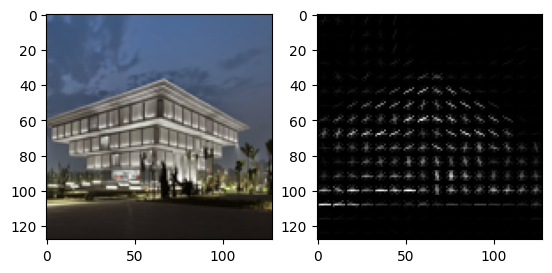

In [4]:
path = '/Users/mt/data/Landmark_Classification/train/bao_tang_ha_noi/604b38902328ac2a.jpg'

img = PIL.Image.open(path).resize((128, 128))
img_hog = preprocess(img)

_, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(img)
axes[1].imshow(img_hog.squeeze(dim=0), cmap=plt.cm.gray)

## Load train dataset, dataloader

In [5]:
path = '/Users/mt/data/Landmark_Classification/train/'

ds_train = datasets.ImageFolder(root=path, transform=preprocess)
dloader_train = data.DataLoader(ds_train, batch_size=10)

In [6]:
classes = ds_train.classes

torch.Size([1, 128, 128])


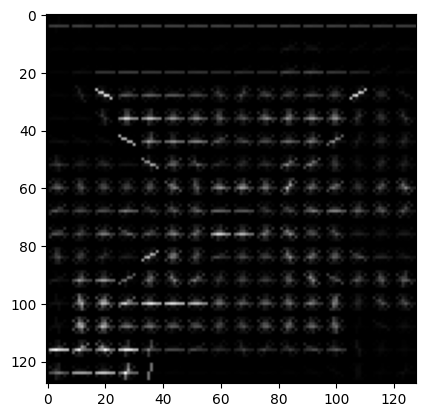

In [7]:
print(ds_train[0][0].shape)
plt.imshow(ds_train[0][0].squeeze(dim=0), cmap=plt.cm.gray)

## Define model

In [14]:
class LandmarkModel(nn.Sequential):
    def __init__(self):
        super(LandmarkModel, self).__init__(
            # layer:    1
            # input:    (1,128,128)
            # output:   (2,124,124)
            nn.Conv2d(in_channels = 1, out_channels = 2, kernel_size = 5),
            nn.ReLU(),
            
            # layer:    2
            # input:    (2, 124, 124)
            # output:   (2, 62, 62)
            nn.MaxPool2d(2, 2),

            # layer:    3
            # input:    (2,62,62)
            # output:   (4,56,56)
            nn.Conv2d(in_channels = 2, out_channels = 4, kernel_size = 7),
            nn.ReLU(),

            # layer:    4
            # input:    (4,56,56)
            # output:   (4,28,28)
            nn.MaxPool2d(2, 2),
            
            # layer:    5
            # input:    (4,28,28)
            # output:   (3136)
            nn.Flatten(),

            # linear layers
            nn.Linear(in_features = 3136, out_features = 1024),
            nn.Linear(in_features = 1024, out_features = 256),
            nn.Linear(in_features = 256, out_features = 30),     # 30: number of classes

            nn.Softmax(dim=1)
        )

model = LandmarkModel()

## Train model

In [16]:
n_epoch = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(n_epoch):

    for batch, (images, labels) in enumerate(dloader_train):
        X = images
        y = nn.functional.one_hot(labels, num_classes=30).float()
        
        y_pred = model(X)

        loss = loss_fn(y, y_pred)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            print('epoch', epoch, '\tbatch', batch, '\tloss', loss)


epoch 0 	batch 0 	loss tensor(3.4245, grad_fn=<DivBackward1>)
epoch 0 	batch 50 	loss tensor(3.4220, grad_fn=<DivBackward1>)
epoch 0 	batch 100 	loss tensor(3.4260, grad_fn=<DivBackward1>)
epoch 1 	batch 0 	loss tensor(3.4245, grad_fn=<DivBackward1>)
epoch 1 	batch 50 	loss tensor(3.4220, grad_fn=<DivBackward1>)
epoch 1 	batch 100 	loss tensor(3.4260, grad_fn=<DivBackward1>)
epoch 2 	batch 0 	loss tensor(3.4245, grad_fn=<DivBackward1>)
epoch 2 	batch 50 	loss tensor(3.4220, grad_fn=<DivBackward1>)
epoch 2 	batch 100 	loss tensor(3.4260, grad_fn=<DivBackward1>)


## Predict an single image

In [10]:
path = '/Users/mt/data/Landmark_Classification/train/bao_tang_ha_noi/604b38902328ac2a.jpg'
img = PIL.Image.open(path).resize((128, 128))
img_hog = preprocess(img)
X = img_hog.unsqueeze(dim = 0)
y_pred = model(X)

max_idx = y_pred.argmax()
max_cls = classes[max_idx]
print(max_cls)

thap_cham
